In [17]:

import matplotlib
from matplotlib import pyplot as plt
import numpy as np
import torch
import math
import json

""" import copy
import networkx as nx
from tqdm import tqdm
from torch.utils.data import DataLoader
from crp.concepts import ChannelConcept
import time
from expbasics.nmf import sample_cavs, nmf, nearest_neighbors, vis_nearest_neighbors, load_cavs, sample_relevance_cavs, sample_bbox_cavs, sample_all_relevances_cavs

from expbasics.dim_reduction import visualize_dr, get_dr_methods, clean_centroids, centroid_distances
from expbasics.biased_noisy_dataset import get_biased_loader, BiasedNoisyDataset
from expbasics.test_dataset import TestDataset
from expbasics.causal_discovery import remove_empty, causal_discovery
from expbasics.ground_truth_measures import GroundTruthMeasures """

from PIL import Image
from crp.image import imgify, vis_opaque_img, plot_grid
from expbasics.helper import get_attributions, get_model_etc, to_name
from expbasics.crp_attribution import CRPAttribution
from expbasics.network import load_model, train_network, accuracy_per_class

from expbasics.visualizations import sum_it, data_iterations, my_plot_grid

%reload_ext autoreload
%autoreload 2

In [176]:
ALL_MEASURES = [
    "m0_rho",
    "m0_mi",
    "m0_phi",
    #"m1_mlc_euclid_n",
    #"m1_mlc_euclid_u",
    "m1_pf",
    "m1_mlc_euclid_norm",
    "m1_mlc_euclid_abs_norm",
    "m1_mlc_euclid",
    "m2_crv",
    "m2_mac_euclid",
    #"m2_mac_euclid_u",
    #"m2_mac_euclid_weigh",
    "m2_rra",
    "m2_pg",
    #"m2_relative_mask",
    "m2_rma",
    "m2_pg_weigh",
    "m2_relative_mask_weigh",
    "m2_rra_weigh",
    "m2_mac_euclid_abs_norm",
    "m2_mac_euclid_norm",
    "m2_mac_euclid_weigh_abs_norm",
    "m2_mac_euclid_weigh_norm",
    "m2_mac_absolute_weigh",
    "m2_mac_absolute",
]

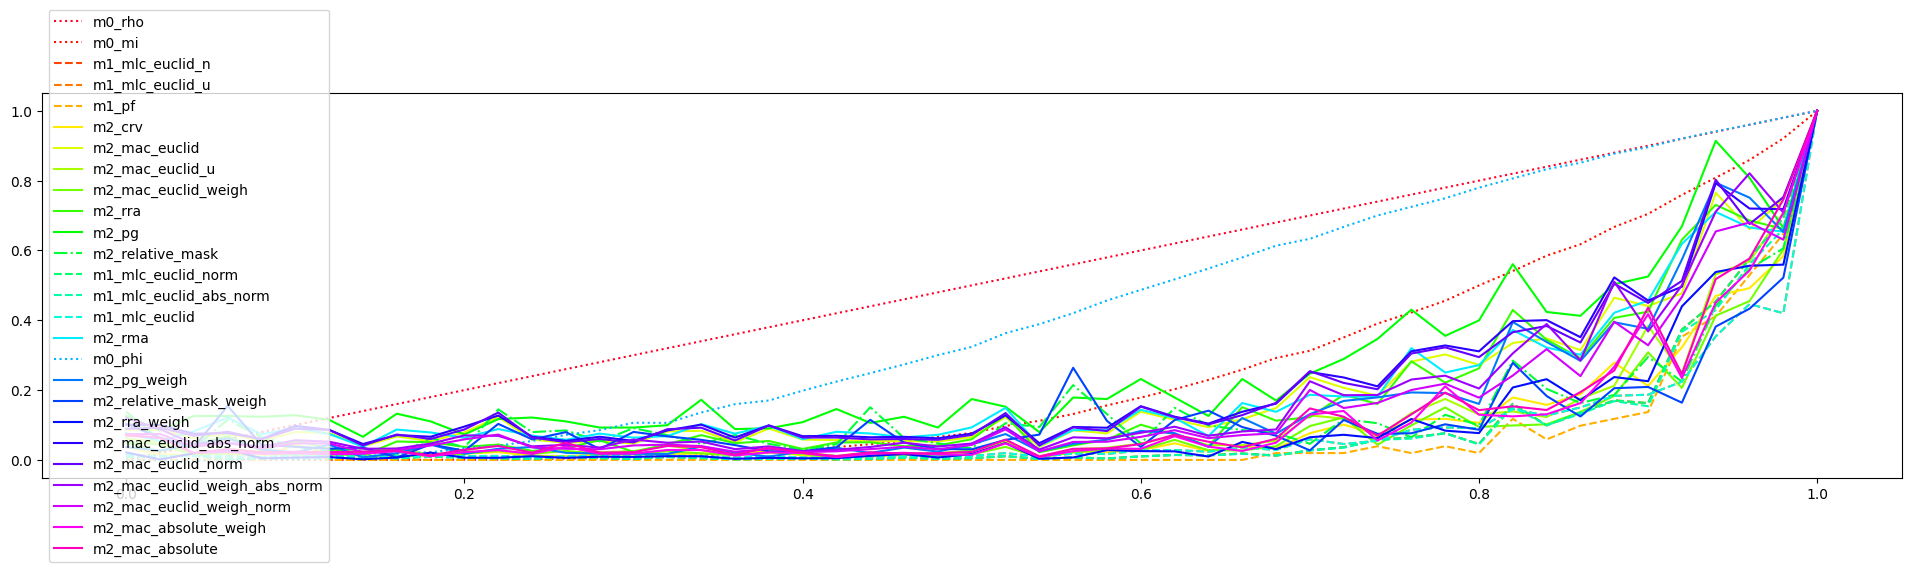

In [228]:
with open("over_rho.json", "r") as f:
    all_vals = json.load(f)
biases = []

labels = all_vals["0.0"].keys() # ALL_MEASURES
mlen = len(labels)
colors = matplotlib.cm.gist_rainbow(np.linspace(0, 1, mlen))#.gist_rainbow(np.linspace(0, 1, mlen))  # type: ignore
vals = np.zeros((mlen,51))
for bi, b in enumerate(all_vals.keys()):
    biases.append(float(b))
    for i, k in enumerate(labels):
        vals[i, bi] = all_vals[b][k]
biases = np.array(biases)
plt.figure(figsize=(24,5))
col = 0
for i, l in enumerate(labels):
    linestyle = "dashed" if l.startswith("m1") else "solid"
    linestyle = "dotted" if l.startswith("m0") else linestyle
    linestyle = "dashdot" if l == "m2_relative_mask" else linestyle
    item = vals[i,:] / (vals[i,:].max() + 1e-10)
    plt.plot(biases,item,label=l, c=colors[i],linestyle=linestyle)
    col +=1
plt.legend(loc="center left")

(51,) (10, 16, 51)


/tmp/ipykernel_11394/2279942493.py:22: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(biases,item,label=label, c=colors[i])


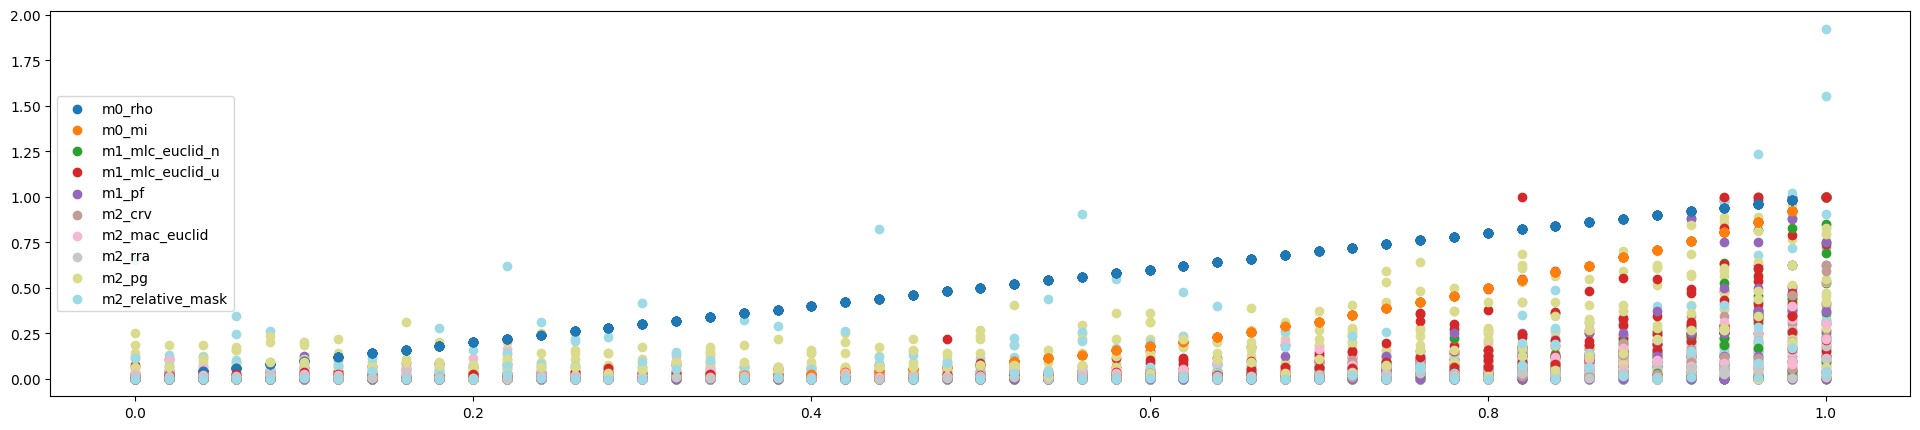

In [153]:
with open("models_values.json", "r") as f:
    models_values = json.load(f)
biases = []
labels = ALL_MEASURES
mlen = len(labels)
colors = matplotlib.cm.tab20(np.linspace(0, 1, mlen))#.gist_rainbow(np.linspace(0, 1, mlen))  # type: ignore
vals = np.zeros((mlen,16,51))
for bi, b in enumerate(models_values.keys()):
    biases.append(float(b))
    for num_it in models_values[b].keys():
        for i, k in enumerate(labels):
            vals[i,int(num_it), bi] = models_values[b][num_it][k]
biases = np.array(biases)
print(biases.shape, vals.shape)
plt.figure(figsize=(24,5))
for n in range(16):
    for i, l in enumerate(labels):
        label = l if n == 0 else ""
        item = vals[i,n,:]
        if l == "m1_mlc_euclid_u":# or l == "m2_mac1":
            item = vals[i,n,:] / (vals[i,n,:].max() + 1e-10)
        plt.scatter(biases,item,label=label, c=colors[i])
plt.legend(loc="center left")

In [152]:
list(
    np.round(np.linspace(0, 1, 11), 3)
)

[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

In [17]:
#iterations * rhos * images * types
16*51* 10 * 2

8160

tensor([0.0331, 0.0014, 0.0887, 0.0190, 0.0116, 0.0952, 0.0018, 0.0475, 0.0000,
        0.3040, 0.0904, 0.1020, 0.1892, 0.0160, 0.0768, 0.0467, 0.0000, 0.3093,
        0.1437, 0.0118, 0.0405, 0.0302, 0.0890, 0.0534, 0.0884, 0.0688, 0.0000,
        0.0621, 0.0248, 0.0673, 0.0000, 0.0000]) tensor(0.2113)


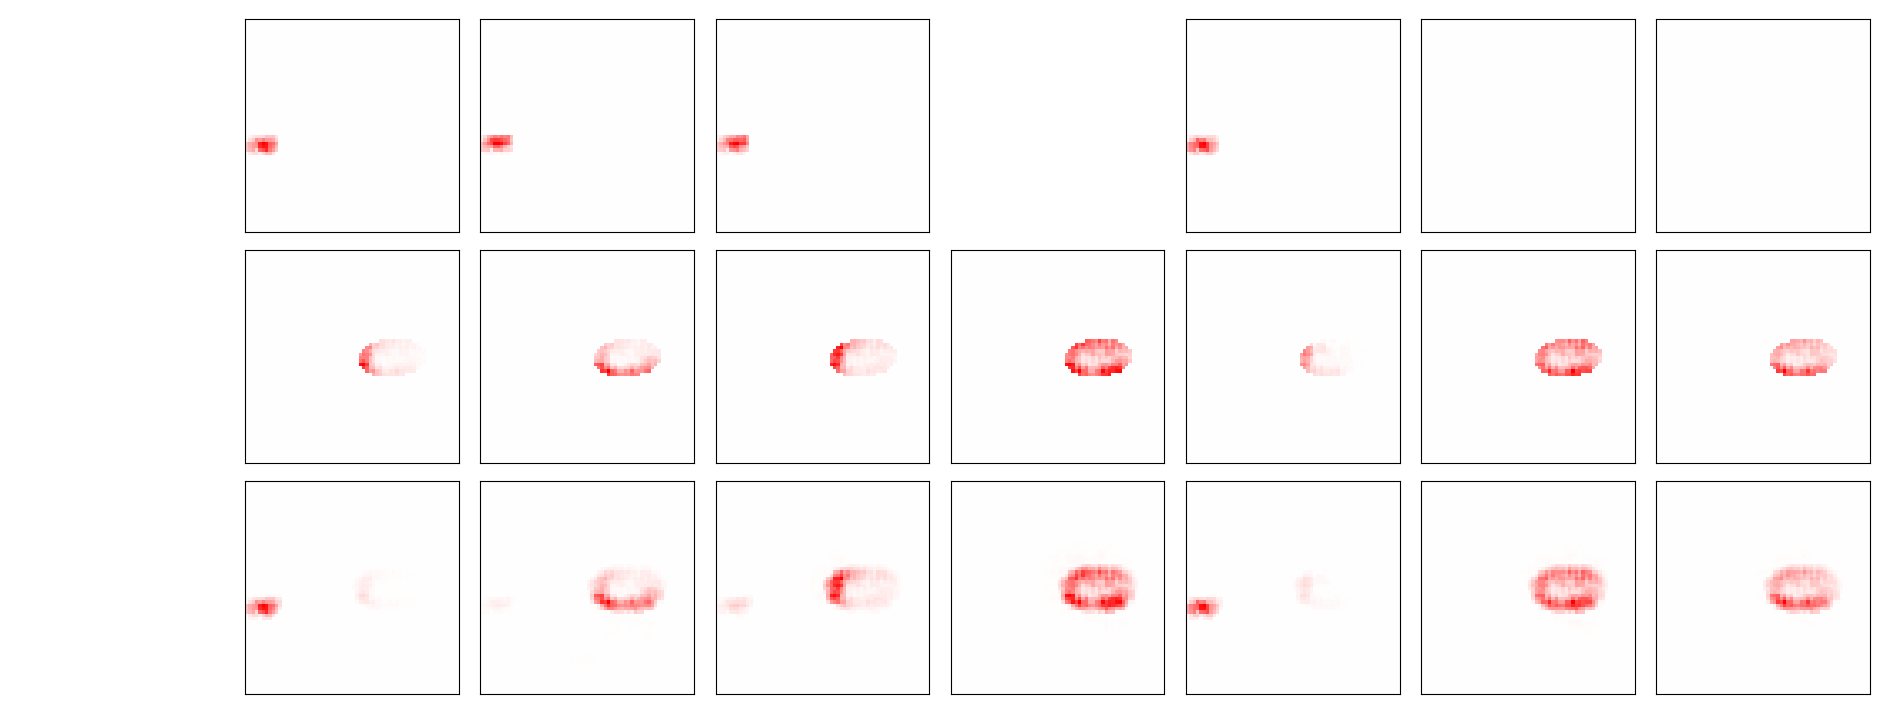

In [208]:
from measures0_to_2 import AllMeasures

bias = 1.0
num_it = 2
name = to_name(bias, num_it)
NAME = "../clustermodels/final"
ms = AllMeasures("../dsprites-dataset/images/", 5)
layer_name = "convolutional_layers.6"
index = 390000
model = load_model(NAME, bias, num_it)
crpa = CRPAttribution(model, ms.ds, "test", name)

image = ms.ds.load_image_wm(index, True)
image0 = ms.ds.load_image_wm(index, False)
lat, _, offset = ms.ds.get_item_info(index)
label = lat[0]
relevances =torch.cat(
                            [
                                ms.relevances(image, label, l, crpa)
                                for l in list(crpa.layer_id_map.keys())
                            ]
                        )
relevances0 =torch.cat(
                            [
                                ms.relevances(image0, label, l, crpa)
                                for l in list(crpa.layer_id_map.keys())
                            ]
                        )
diff = torch.abs(relevances- relevances0)
print(diff, diff.sum() / (2*len(list(crpa.layer_id_map.keys()))))
wm_mask = torch.zeros(64, 64)
wm_mask[
    max(0, 57 + offset[0]) : max(0, 58 + offset[0]) + 5,
    max(offset[1] + 3, 0) : max(offset[1] + 4, 0) + 10,
] = 1
shape_mask = ms.ds.load_shape_mask(index)
nlen = 8
conditions = [{layer_name: [i]} for i in crpa.layer_id_map[layer_name]]
res = 0.0

images = torch.zeros(3, nlen, 64, 64)
for attr in crpa.attribution.generate(
    image,
    conditions,
    crpa.composite,
    start_layer="linear_layers.2",
    record_layer=crpa.layer_names,
    verbose=False,
    batch_size=nlen,
):
    heatmaps_abs = attr.heatmap.abs()
    total_rel = torch.sum(heatmaps_abs, dim=(1, 2))
    images[0, :, :, :] = heatmaps_abs * wm_mask
    images[1, :, :, :] = heatmaps_abs * shape_mask[0]
    images[2, :, :, :] = heatmaps_abs
    wm_rel = torch.sum(heatmaps_abs * wm_mask, dim=(1, 2))
    shape_rel = torch.sum(heatmaps_abs * shape_mask[0], dim=(1, 2))
    vals = torch.zeros(nlen)
    for i in range(nlen):
        if wm_rel[i] > (shape_rel[i] * (wm_mask.sum() / (shape_mask.sum()))):
            vals[i] = wm_rel[i]
        else:
            vals[i] = 0
images = images.detach()
my_plot_grid(images, 3, nlen, resize=3)

242.0 [0.0, 0.534207820892334, 0.026740774512290955, 0.004481002688407898, 0.001689862459897995, 0.0020056376233696938, 0.007760591804981232, 0.003170924261212349] 0.5800566142424941


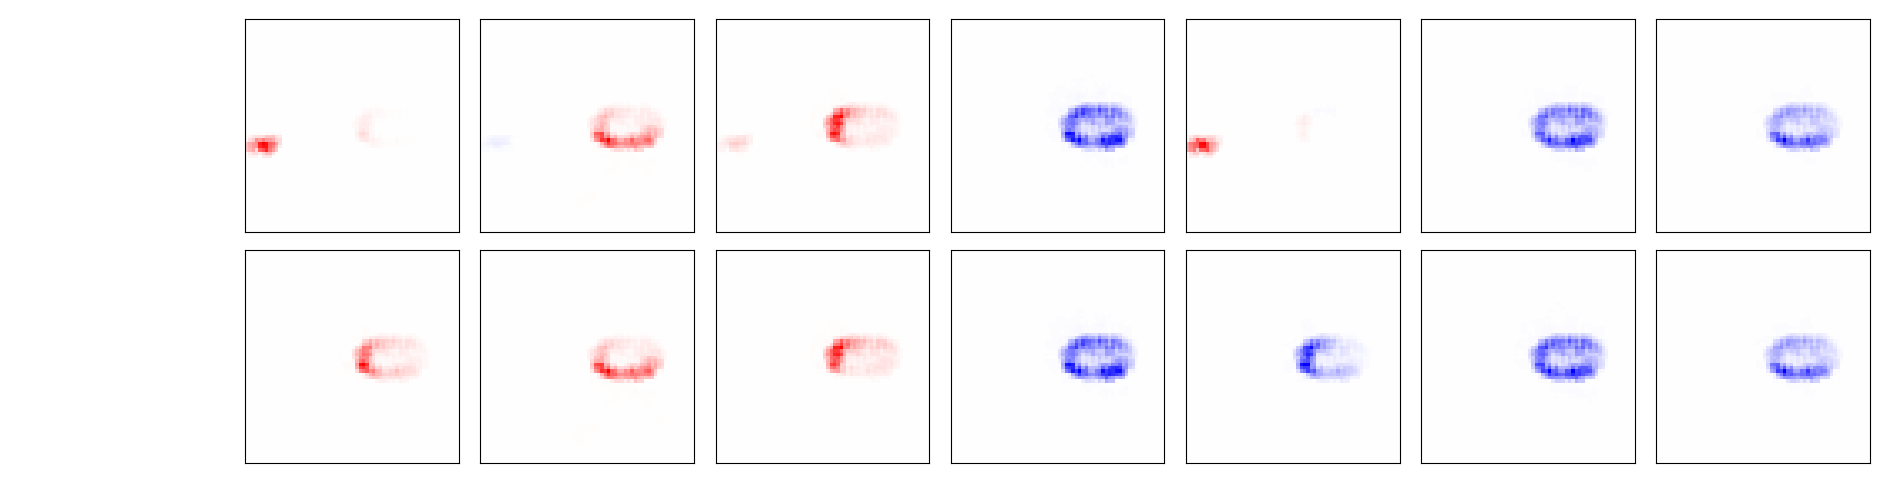

In [213]:
image1 = ms.ds.load_image_wm(index, True)
image0 = ms.ds.load_image_wm(index, False)

diff_heatmaps = torch.zeros(2, nlen, 64, 64)
hm1 = ms.heatmaps(image1, wm_mask, layer_name, crpa)
hm0 = ms.heatmaps(image0, wm_mask, layer_name, crpa)
diff_heatmaps[0, :, :, :] = hm1["heatmaps"]
diff_heatmaps[1, :, :, :] = hm0["heatmaps"]
def kernel(a,b):
    return torch.nn.functional.conv2d(a, a) - 2*torch.nn.functional.conv2d(a, b) + torch.nn.functional.conv2d(b, b) 

truediff = kernel(wm_mask.view(1,1,64,64), shape_mask.view(1,1,64,64)) 
diffs = []
batched = kernel(hm1["heatmaps"].view(nlen,1,64,64), hm0["heatmaps"].view(nlen,1,64,64))
print(float(truediff), [float(batched[i,i].flatten()) for i in range(8)], sum([float(batched[i,i].flatten()) for i in range(8)]))
my_plot_grid(diff_heatmaps, 2, nlen, resize=3)
